In [1]:
import os
import shutil
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2022-01-18 11:13:29.316361: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-18 11:13:29.316398: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
file_path = "data/mini_speech_commands/test"
if os.path.exists(file_path):
    shutil.rmtree(file_path)

## Import the mini Speech Commands dataset



In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [4]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['yes' 'left' 'stop' 'no' 'right' 'up' 'go' 'down']


In [5]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

2022-01-18 11:13:48.753518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-18 11:13:48.753578: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-18 11:13:48.753616: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vikesh-hp-notebook): /proc/driver/nvidia/version does not exist
2022-01-18 11:13:48.754033: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/down/31270cb2_nohash_0.wav', shape=(), dtype=string)


In [6]:
filenames

<tf.Tensor: shape=(8000,), dtype=string, numpy=
array([b'data/mini_speech_commands/down/31270cb2_nohash_0.wav',
       b'data/mini_speech_commands/left/bfb10243_nohash_0.wav',
       b'data/mini_speech_commands/down/30137d34_nohash_1.wav', ...,
       b'data/mini_speech_commands/yes/9b5815cd_nohash_0.wav',
       b'data/mini_speech_commands/yes/f0ac2522_nohash_1.wav',
       b'data/mini_speech_commands/left/748cb308_nohash_1.wav'],
      dtype=object)>

In [7]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [8]:
train_files

<tf.Tensor: shape=(6400,), dtype=string, numpy=
array([b'data/mini_speech_commands/down/31270cb2_nohash_0.wav',
       b'data/mini_speech_commands/left/bfb10243_nohash_0.wav',
       b'data/mini_speech_commands/down/30137d34_nohash_1.wav', ...,
       b'data/mini_speech_commands/stop/541120c7_nohash_1.wav',
       b'data/mini_speech_commands/no/4249c833_nohash_0.wav',
       b'data/mini_speech_commands/right/c948d727_nohash_0.wav'],
      dtype=object)>

## Read the audio files and their labels

In [9]:
test_file = tf.io.read_file(DATASET_PATH+'/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

In [10]:
test_audio

<tf.Tensor: shape=(13654, 1), dtype=float32, numpy=
array([[0.00177002],
       [0.00299072],
       [0.00283813],
       ...,
       [0.02526855],
       [0.02972412],
       [0.01776123]], dtype=float32)>

In [11]:
def decode_audio(audio_binary):
    # Decode WAV-encoded audio files to `float32` tensors, normalized
    # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
    audio, _ = tf.audio.decode_wav(contents=audio_binary)
    # Since all the data is single channel (mono), drop the `channels`
    # axis from the array.
    return tf.squeeze(audio, axis=-1)

In [12]:
def get_label(file_path):
    parts = tf.strings.split(
        input=file_path,
        sep=os.path.sep)
    # Note: You'll use indexing here instead of tuple unpacking to enable this
    # to work in a TensorFlow graph.
    return parts[-2]

In [13]:
def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

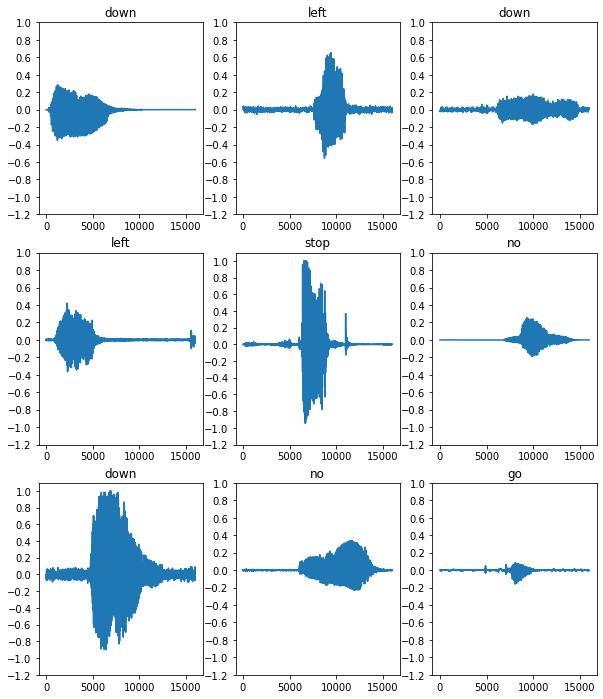

In [15]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)

plt.show()

In [16]:
def get_spectrogram(waveform):
    # Zero-padding for an audio waveform with less than 16,000 samples.
    input_len = 16000
    waveform = waveform[:input_len]
    zero_padding = tf.zeros(
        [16000] - tf.shape(waveform),
        dtype=tf.float32)
    # Cast the waveform tensors' dtype to float32.
    waveform = tf.cast(waveform, dtype=tf.float32)
    # Concatenate the waveform with `zero_padding`, which ensures all audio
    # clips are of the same length.
    equal_length = tf.concat([waveform, zero_padding], 0)
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        equal_length, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [17]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [18]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

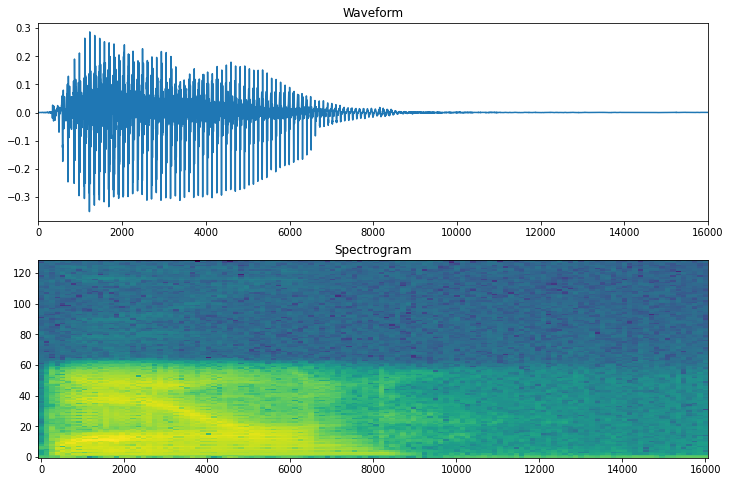

In [19]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now, define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs:

In [20]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [21]:
spectrogram_ds = waveform_ds.map(
    map_func=get_spectrogram_and_label_id,
    num_parallel_calls=AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

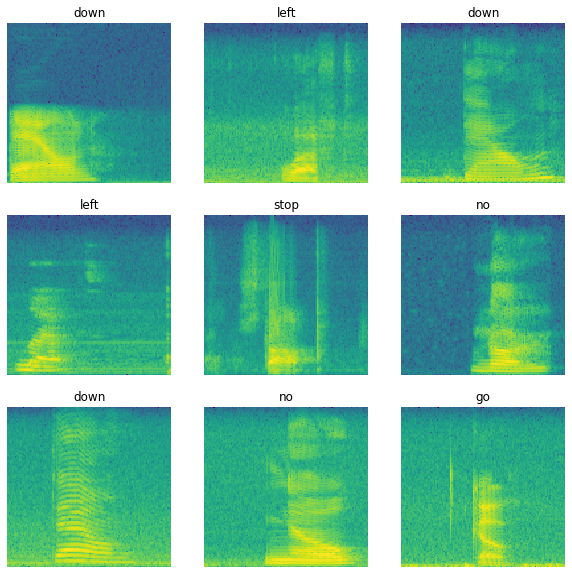

In [22]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.show()

## Build and train the model

Repeat the training set preprocessing on the validation and test sets:

In [23]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(
        map_func=get_waveform_and_label,
        num_parallel_calls=AUTOTUNE)
    output_ds = output_ds.map(
        map_func=get_spectrogram_and_label_id,
        num_parallel_calls=AUTOTUNE)
    return output_ds

In [24]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training:

In [25]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [27]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

## restart work from here

In [28]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 1)        3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [29]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [30]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


2022-01-18 11:15:48.504575: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 12845056 exceeds 10% of free system memory.
2022-01-18 11:15:48.853189: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 12845056 exceeds 10% of free system memory.
2022-01-18 11:15:49.174443: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24385536 exceeds 10% of free system memory.


  1/100 [..............................] - ETA: 4:14 - loss: 2.1000 - accuracy: 0.1719

2022-01-18 11:15:49.592297: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 12845056 exceeds 10% of free system memory.
2022-01-18 11:15:49.762766: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 12845056 exceeds 10% of free system memory.


100/100 [==============================] - 42s 398ms/step - loss: 1.7287 - accuracy: 0.3809 - val_loss: 1.2988 - val_accuracy: 0.6087
Epoch 2/10
100/100 [==============================] - 34s 343ms/step - loss: 1.1746 - accuracy: 0.5845 - val_loss: 0.9288 - val_accuracy: 0.7100
Epoch 3/10
100/100 [==============================] - 30s 298ms/step - loss: 0.9090 - accuracy: 0.6769 - val_loss: 0.7837 - val_accuracy: 0.7650
Epoch 4/10
100/100 [==============================] - 31s 311ms/step - loss: 0.7705 - accuracy: 0.7266 - val_loss: 0.7370 - val_accuracy: 0.7675
Epoch 5/10
100/100 [==============================] - 31s 311ms/step - loss: 0.6605 - accuracy: 0.7683 - val_loss: 0.6664 - val_accuracy: 0.7862
Epoch 6/10
100/100 [==============================] - 31s 312ms/step - loss: 0.5717 - accuracy: 0.7978 - val_loss: 0.6389 - val_accuracy: 0.8138
Epoch 7/10
100/100 [==============================] - 30s 292ms/step - loss: 0.5272 - accuracy: 0.8127 - val_loss: 0.6423 - val_accuracy: 0.8

Let's plot the training and validation loss curves to check how your model has improved during training:

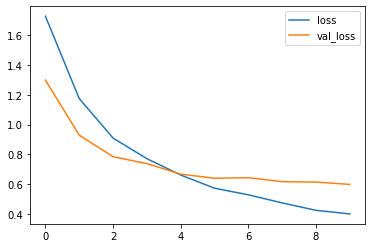

In [31]:
metrics =history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [32]:
model.save("model")

2022-01-18 11:23:34.573480: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: model/assets


## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [33]:
model = tf.keras.models.load_model('model')

In [34]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [35]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 84%


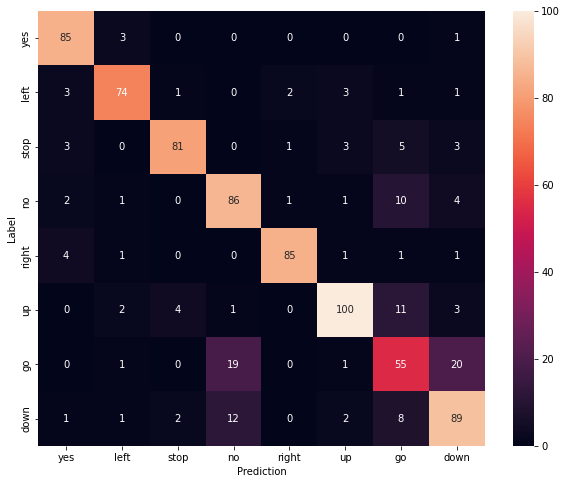

In [36]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

In [36]:
file_path = "data/mini_speech_commands/test"
if os.path.exists(file_path):
    shutil.rmtree(file_path)
os.mkdir(file_path)

In [37]:
# Sampling frequency
freq = 16000
# Recording duration
duration = 1.5

In [44]:
# Start recorder with the given values of 
# duration and sample frequency
recording = sd.rec(int(duration * freq), samplerate=freq, channels=1)
# Record audio for the given number of seconds
sd.wait()
write(data_dir/'test/recording_0.wav', freq, recording)
!ffmpeg -y -v 0 -i data/mini_speech_commands/test/recording_0.wav -map 0:a:0 -b:a 256k data/mini_speech_commands/test/recording_1.wav
            
sample_file = data_dir/'test/recording_1.wav'

files_ds = tf.data.Dataset.from_tensor_slices([str(sample_file)])
waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Waveform shape: (24000,)
Spectrogram shape: (124, 129, 1)
Audio playback


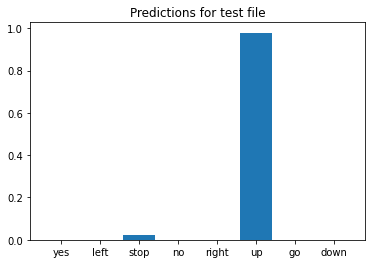

In [45]:
# sample_file = data_dir/'right/0c5027de_nohash_1.wav'
sample_file = data_dir/'test/recording_1.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram_1, label in sample_ds.batch(1):
    prediction = model(spectrogram_1)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for test file')
    plt.show()

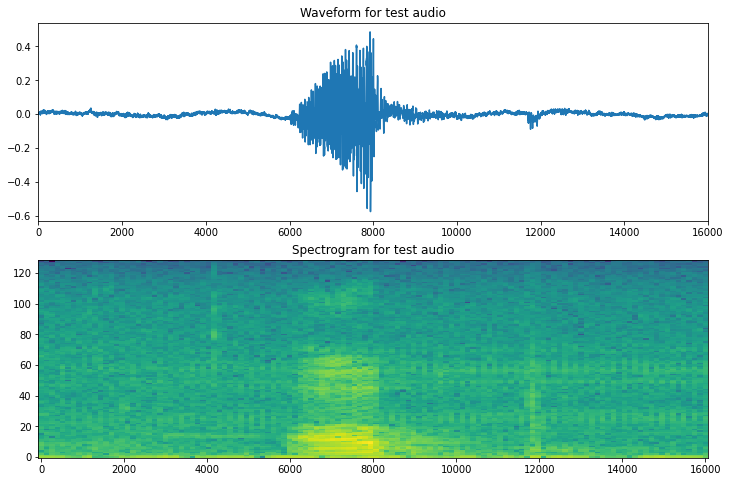

In [46]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform for test audio')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram for test audio')
plt.show()

In [47]:
print("file similar to audio file")
pred_label = commands[np.argmax(tf.nn.softmax(prediction[0]).numpy())]
folder_path = "data/mini_speech_commands/" + pred_label
for root, folders, files in os.walk(folder_path):
    break
file_path = folder_path + "/" + files[np.random.randint(0, 1000)]
sample_file = file_path
files_ds = tf.data.Dataset.from_tensor_slices([str(sample_file)])
waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

file similar to audio file
Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


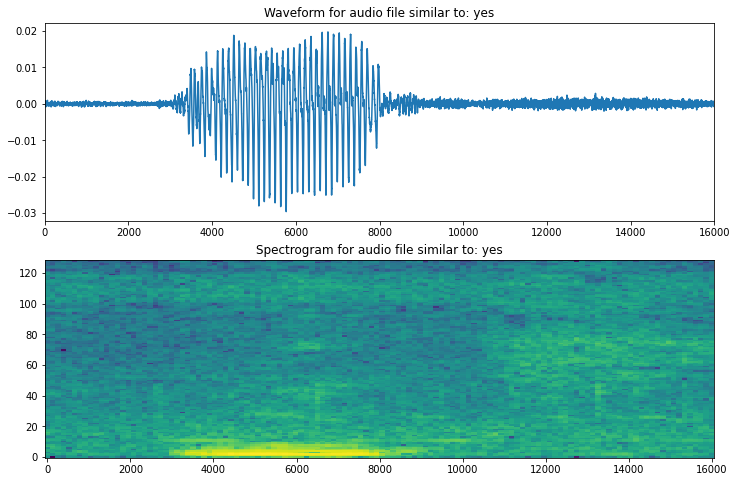

In [42]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform for audio file similar to: ' + pred_label)
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram for audio file similar to: ' + pred_label)
plt.show()